# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: ML Modell erstellen

Hier in diesem Notebook erstellen wir unsere Machine Learning Modelle.

---

# Libraries Importieren

In [ ]:
# Data Science Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Preprocessing 
from sklearn.model_selection import train_test_split, GroupShuffleSplit

# ML Models
## import logistic regression
from sklearn.linear_model import LogisticRegression

## Decision Tree
from sklearn.tree import DecisionTreeClassifier

## Random Forest
from sklearn.ensemble import RandomForestClassifier

## KNN
from sklearn.neighbors import KNeighborsClassifier

## SVM
from sklearn.svm import SVC

## Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

# import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import wandb
import wandb

# import config.py for wandb API_KEY
import config
# login to wandb with config 
wandb.login(key=config.API_KEY)

print("Successfull wandb login: ", wandb.login())


# Daten einlesen

- Einlesen der unprocessierten Daten
- Einlesen der getrimmten und aggregierten Daten

In [ ]:
# File: Alle_Messungen.csv (Raw Data) einlesen
raw_unprocessed_data = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/Alle_Messungen.csv", index_col=0)
data = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/data_trimmed_aggregated_windows_size_5s.csv")
# display head 
display("raw_unprocessed_data " + str(raw_unprocessed_data.shape), raw_unprocessed_data.head())
display("data " + str(data.shape), data.head())

## Preprocessing der Daten für Baseline Modell

Für das Baseline Modell werden die Daten wie folgt verarbeitet:

- Entfernen der Zeilen, die NaN Werte aufweisen
- Die Anzahl Observationen gleichmässig auf die minimale Anzahl Observationen pro Klasse sampeln
- Die Daten werden in Trainings und Validierungsdaten gesplittet, dabei sollten die Anzahl der Werte in 'class' gleichmaessig verteilt sein
- Die Verteilung der Klassen wird mittels einem Barplot gezeigt
- Das erstellen eines Logistischen Regression Modell fuer multiple Klassen, mittels sklearn
- Berechnung der Accuracy sowie Visualisierung der Confusion Matrix

Fragen: 

- Warum wurde hier nicht nach "id_combined" gesplittet?  
Hier handelt es sich um die unverarbeiteten Daten, also die Daten, die wir weder getrimmt (5 Sekunden Schnitt) noch aggregiert haben. Die Daten sind also noch in der Form, wie sie vom Sensor kommen. Da es sich hierbei um ein Baseline Model handelt, haben wir uns dazu entschieden, die Daten nicht nach "id_combined" zu splitten.

In [ ]:
# remove na rows from raw_unprocessed_data
raw_unprocessed_data = raw_unprocessed_data.dropna(axis = 0)

# drop uneccessary columns for the baseline modell
baseline_data = raw_unprocessed_data.drop(['time', 'id', 'user', 'id_combined'], axis = 1)

# get the number of observation for each class and select the minimum
min_class = baseline_data['class'].value_counts().min()

# Select the min_class of each class to get an equal number of observations for each class
baseline_data = baseline_data.groupby('class').sample(n = min_class, random_state=42)

# split the data into baselin_train_X, baseline_train_y, baseline_test_X, baseline_test_y 
baseline_train_X, baseline_val_X, baseline_train_y, baseline_val_y = train_test_split(baseline_data.drop('class', axis = 1), baseline_data['class'], test_size = 0.2, random_state = 42)

# plot the class distribution of the baselin_data, baseline_train_y and baseline_test_y in 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

# plot the class distribution of the baseline_data
baseline_data['class'].value_counts().plot(kind = "bar", ax = ax1, color = "lightblue", edgecolor = "black", linewidth = 1)
ax1.set_xlabel("Class")
ax1.set_ylabel("Number of Observations")
ax1.set_title("Number of Observations per Class in Baseline Data")

# plot the class distribution of the baseline_train_y
baseline_train_y.value_counts().plot(kind = "bar", ax = ax2, color = "lightblue", edgecolor = "black", linewidth = 1)
ax2.set_xlabel("Class")
ax2.set_ylabel("Number of Observations")
ax2.set_title("Number of Observations per Class in Train Data")

# plot the class distribution of the baseline_test_y
baseline_val_y.value_counts().plot(kind = "bar", ax = ax3, color = "lightblue", edgecolor = "black", linewidth = 1)
ax3.set_xlabel("Class")
ax3.set_ylabel("Number of Observations")
ax3.set_title("Number of Observations per Class in Validate Data")

# set the title of the figure and optimize the layout of the subplots
fig.suptitle("Class Distribution of Baseline Data, Train and Test Data", fontsize = 16)
plt.tight_layout()
plt.show()


--- 

# Preprocessing der Daten für die ML-Modelle

- Damit wir ein Data Leakage vermeiden, splitten wir die Daten aufgrund von id_combined, somit stellen wir sicher, dass die Daten, die wir für das Training verwenden, nicht in der Validierung verwendet werden.
- Weil wir die Accuracy Metrik haben, ist es uns wichtig, dass die "Class" gleichverteilt ist sowohl beim Training als auch beim Test Datensatz. Die Funktin ermoeglicht es uns die Daten zu splitten, sodass die Verteilung der Klassen gleich ist. 


In [ ]:
# Create function
def preprocess_data(data, test_size=0.2, random_state_split=42, make_plot=False, undersample=False, oversample=False):
    # Split data into train and validation sets using GroupShuffleSplit
    df_train_idx, df_val_idx = next(iter(sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state_split).split(data, groups=data['id_combined'])))
    df_train_ = data.iloc[df_train_idx]
    df_val_ = data.iloc[df_val_idx]

    # Undersample if specified, else oversample if specified, else keep original dataset
    if undersample and not oversample:
        print("undersample dataset")
        df_train = df_train_.groupby('class').sample(n = df_train_['class'].value_counts().min(), random_state=random_state_split)
        df_val = df_val_.groupby('class').sample(n = df_val_['class'].value_counts().min(), random_state=random_state_split)
    elif oversample and not undersample:
        print("oversample dataset")
        df_train = df_train_.groupby('class').sample(n = df_train_['class'].value_counts().max(), replace=True, random_state=random_state_split)
        df_val = df_val_.groupby('class').sample(n = df_val_['class'].value_counts().max(), replace=True, random_state=random_state_split)

        #df_train = df_train_.groupby('class').apply(lambda x: x.sample(df_train_['class'].value_counts().max(), replace=True, random_state=42))
        #df_val = df_val_.groupby('class').apply(lambda x: x.sample(df_val_['class'].value_counts().max(), replace=True, random_state=42))
    else:
        print("no undersampling or oversampling")
        df_train = df_train_
        df_val = df_val_

    # Plot class distribution if specified
    if make_plot:
        # create counterplot for the class distribution of train and test data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

        # plot the class distribution of the train data
        df_train['class'].value_counts().plot(kind = "bar", ax = ax1, color = "lightblue", edgecolor = "black", linewidth = 1)
        ax1.set_xlabel("Class")
        ax1.set_ylabel("Number of Observations")
        ax1.set_title("Number of Observations per Class in Train Data")
        for p in ax1.patches:
            ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        # plot the class distribution of the test data
        df_val['class'].value_counts().plot(kind = "bar", ax = ax2, color = "lightblue", edgecolor = "black", linewidth = 1)
        ax2.set_xlabel("Class")
        ax2.set_ylabel("Number of Observations")
        ax2.set_title("Number of Observations per Class in Validate Data")
        for p in ax2.patches:
            ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        # set the title of the figure and optimize the layout of the subplots
        fig.suptitle("Class Distribution of Train and Validate Dataz\n undersample: " + str(undersample) + " ,oversample: " + str(oversample), fontsize = 16)
        plt.tight_layout()
        plt.show()

    # cols that should be dropped from the dataset
    cols_to_drop = ['time', 'Accelerometer_x', 'Accelerometer_y', 'Accelerometer_z', 'Gyroscope_x', 'Gyroscope_y', 'Gyroscope_z', 'Magnetometer_x',
                    'Magnetometer_y', 'Magnetometer_z', 'Orientation_qx', 'Orientation_qy', 'Orientation_qz', 'id', 'user', 'id_combined']
    
    # Drop columns
    df_train = df_train.drop(cols_to_drop, axis=1)
    df_val = df_val.drop(cols_to_drop, axis=1)

    # drop rows with NaN Values (cause from the export_aggregated_df(concat_only=True) function, there exists rows with NaN values)
    df_train = df_train.dropna()
    df_val = df_val.dropna()

    # Creata X and y 
    y_train = df_train['class']
    X_train = df_train.drop('class', axis=1)
    y_val = df_val['class']
    X_val = df_val.drop('class', axis=1)

    # Return preprocessed data
    return X_train, y_train, X_val, y_val

In [ ]:
# preprocess data function with undersampling
preprocess_data(data, test_size=0.2, random_state_split=3, make_plot=True, undersample=False, oversample=True)
# preprocess data function with oversampling
preprocess_data(data, test_size=0.3, random_state_split=5, make_plot=True, undersample=True, oversample=False)
# preprocess data function with no undersampling or oversampling
preprocess_data(data, test_size=0.3, random_state_split=7, make_plot=True, undersample=False, oversample=False)

print("Oversample and Undersampling Data Works")

---
# Baseline Modell 

Unser Baseline Modell ist ein Logistisches Regression Modell. Wir haben uns für dieses Modell entschieden, da es einfach zu implementieren ist und wir so einen Vergleich zu den anderen Machine Learning Modellen erstellen können.

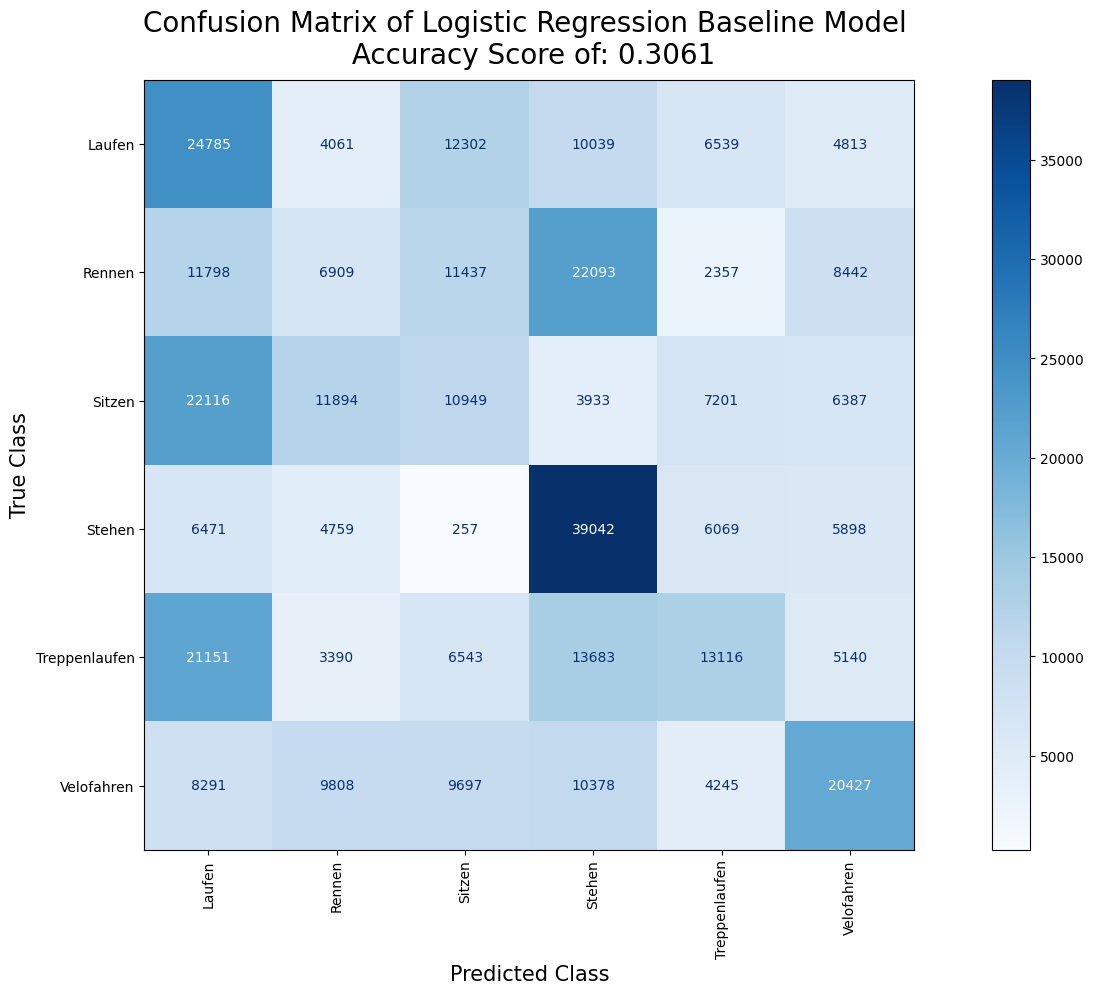

In [10]:
# create a logistic regression model for multiclass classification with sklearn
logistic_regression = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", max_iter = 1000, n_jobs=-1, random_state = 10)

# fit the logistic regression model
logistic_regression.fit(X = baseline_train_X, y = baseline_train_y)

# predict the classes for the val data
baseline_val_y_pred = logistic_regression.predict(X = baseline_val_X)

# calculate the accuracy of the logistic regression model with train data and val data
baseline_val_accuracy = accuracy_score(y_true = baseline_val_y, y_pred = baseline_val_y_pred)

# create a confusion matrix display
baseline_confmatrix = confusion_matrix(y_true = baseline_val_y, y_pred = baseline_val_y_pred)

# plot the confusion matrix of the logistic regression model
fig, ax = plt.subplots(figsize = (20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=baseline_confmatrix, display_labels=logistic_regression.classes_)
disp.plot(ax = ax, cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
plt.title("Confusion Matrix of Logistic Regression Baseline Model \n Accuracy Score of: " + str(round(baseline_val_accuracy, 4)), fontsize = 20, y = 1.01)
plt.xlabel("Predicted Class", fontsize = 15)
plt.ylabel("True Class", fontsize = 15)
plt.show()


---
# Modell-01 - Decision Tree
## Model trainieren

In [ ]:
# Define sweep config for decision tree
sweep_config_dt = {
    'method': 'random',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'criterion': {
            'values': ['gini']
        },
        'splitter': {
            'values': ['best']
        },
        'max_depth': {
            'values': [10]
        },
        'min_samples_split': {
            'values': [10]
        },
        'min_samples_leaf': {
            'values': [10]
        },
        'max_features': {
            'values': ['sqrt']
        },
        'test_size': {
            'values': [0.2]
        },
        'random_state': {
            'min': 1,
            'max': 10000,
        },
        'random_state_split': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [False]
        },
        'oversample': {
            'values': [False]
        },
        'class_weight': {
            'values': ['balanced']
        },
        'ccp_alpha': {
            'values': [0]
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config_dt, project="01-decision-tree")

# Define sweep function
def sweep_dt_train():
    # Initialize wandb
    wandb.init(project="01-decision-tree")

    # Get hyperparameters
    criterion = wandb.config.criterion
    splitter = wandb.config.splitter
    min_samples_split = wandb.config.min_samples_split
    max_depth = wandb.config.max_depth
    min_samples_leaf = wandb.config.min_samples_leaf
    max_features = wandb.config.max_features
    class_weight = wandb.config.class_weight
    ccp_alpha = wandb.config.ccp_alpha
    random_state = wandb.config.random_state

    # Parametres for preprocess data 
    test_size = wandb.config.test_size
    random_state_split = wandb.config.random_state_split
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state_split=random_state_split, 
                                                     undersample=undersample, 
                                                     oversample=oversample)
    
    # create a decision tree model
    dt_model = DecisionTreeClassifier(criterion=criterion,
                                      splitter=splitter,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      class_weight=class_weight,
                                      ccp_alpha=ccp_alpha,
                                      random_state=random_state)
    
    # fit the decision tree model
    dt_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = dt_model.predict(X_val)
    prediction_train = dt_model.predict(X_train)

    # calculate the accuracy of the decision tree model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function=sweep_dt_train)
wandb.finish()
    

## Bestes Modell
Nachdem mit Weights & Bias verschiedene Modelle trainiert und getestet wurden, konnte ein Accuracy Score von 0.8 - 0.9 erreicht werden:

In [ ]:
# train test split
decision_tree_X_train, decision_tree_y_train, decision_tree_X_val, decision_tree_y_val = preprocess_data(data, test_size=0.2, random_state_split=7885, make_plot=False, undersample=False, oversample=False)

# create a logistic regression model for multiclass classification with sklearn
decision_tree = DecisionTreeClassifier(criterion="gini", max_depth=10, max_features="auto", min_samples_leaf=20, min_samples_split=15, splitter="best", random_state=7885, class_weight="balanced", ccp_alpha=0.01)

# fit the logistic regression model
decision_tree.fit(X = decision_tree_X_train, y = decision_tree_y_train)

# predict the classes for the val data
decision_tree_val_y_pred = decision_tree.predict(X = decision_tree_X_val)

# calculate the accuracy of the logistic regression model with train data and val data
decision_tree_val_accuracy = accuracy_score(y_true = decision_tree_y_val, y_pred = decision_tree_val_y_pred)

# create a confusion matrix display
decision_tree_confmatrix = confusion_matrix(y_true = decision_tree_y_val, y_pred = decision_tree_val_y_pred)

# plot the confusion matrix of the logistic regression model
fig, ax = plt.subplots(figsize = (20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=decision_tree_confmatrix, display_labels=decision_tree.classes_)
disp.plot(ax = ax, cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
plt.title("Confusion Matrix of Decision Tree best Model \n Accuracy Score of: " + str(round(decision_tree_val_accuracy, 4)), fontsize = 20, y = 1.01)
plt.xlabel("Predicted Class", fontsize = 15)
plt.ylabel("True Class", fontsize = 15)
plt.show()

## Fehlerabschätzung vom besten Decision Tree Modell

Damit wir wissen, wie gross die Streubreite unserer Metrik ist, wurden vom besten Hyperparamter Run mehrere Modelle mit den gleichen Hyperparameter trainiert, jedoch mit unterschiedlichem random_state split. 

Die Runs wurden ebenfalls ins Weights & Bias gelogt, die Daten als csv extrahiert und hier wieder einglesen und verarbeitet sowie visualisierrt.

## Fazit
Für das Optimieren der Machine Learning Modelle wurde die Plattform Weights and Biases verwendet, um Grid Searches auszuführen und diese zu visualisieren.Durch die Visualisierungen können die trainierten modelle besser verglichen und die besten Parameter ausgewählt werden.
Total wurden über 400 Modelle trainiert und getestet und validiert:
![alt text](images/01_decision_tree/01_decision_tree_all.png "Decision Tree - All Runs")

Zu beginn wurden standard Modellparameter mit üblichen Values getestet. Diese erzielten validation accuracies von 0.29 - 0.93. Das Modell welches am besten performte wurde jedoch mit einer Testsize von 0.1 trainiert, was zu klein ist und daher nicht aussagekräftig ist.
![alt text](images/01_decision_tree/02_desicion_tree_run_1.png "Decision Tree - Run 01")

Die Parameter, welche im ersten run die besten ergebnssse erzielten wurden übernommen und schlecht performte values wurden entfernt.
![alt text](images/01_decision_tree/03_decision_tree_run_2.png "Decision Tree - Run 02")

Auffallend war nun, dass die Testsize 0.1 zu klein gewählt ist, weshalb diese auf 0.2 erhöht wurde.
![alt text](images/01_decision_tree/04_decision_tree_run_3.png "Decision Tree - Run 03")

Erneut wurden nur die gut perfomenden Values übernommen und die Testsuze auf 0.2 fixiert.
![alt text](images/01_decision_tree/05_decision_tree_run_4.png "Decision Tree - Run 04")

Die besten Parameter wurden übernommen und diesmal nur gegenüber des Randomstates von train und test split getestet. Der Decision Tree hängt sehr stark vom Split der Daten ab.
![alt text](images/01_decision_tree/06_decision_tree_run_5.png "Decision Tree - Run 05")

Auch mit dieser Abhängigkeit des Radomstates konnte ein gutes ergebnis erzielt werden. Allerdings ist auffallend, dass die Train Accuracy gegenüber der Test Accuracy sehr hoch ist, was auf ein overfitting hindeutet. Aus diesem Grund wurden die Parameter Class Weight und 
![alt text](images/01_decision_tree/07_decision_tree_run_6.png "Decision Tree - Run 06")

![alt text](images/01_decision_tree/08_decision_tree_run_7.png "Decision Tree - Run 07")

Nach der Evaluierung konnten einige Erkenntnisse gewonnen werden:
- zu wenig Daten
- Scores sind extrem abhängig des Randomstates von train und test split
- overfit
- zu kleine testsize angenommen (danach min 0.2)


---

# Modell-02 - Random Forest

In [ ]:
# CODE
# Define sweep config random forest
sweep_config_rf = {
    'method': 'random',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'n_estimators': {
            'values': [6]
        },
        'criterion': {
            'values': ['gini']
        },
        'max_depth': {
            'values': [10]
        },
        'min_samples_split': {
            'values': [10]
        },
        'min_samples_leaf': {
            'values': [5]
        },
        'max_features': {
            'values': ['sqrt'],
        },
        'bootstrap': {
            'values': [False]
        },
        'test_size': {
            'values': [0.2]
        },
        'random_state': {
            'min': 1,
            'max': 10000,
        },
        'random_state_split': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [False]
        },
        'oversample': {
            'values': [False]
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config_rf, project="02-random-forest")

# Define sweep function
def sweep_rf_train():
    # Initialize wandb
    wandb.init(project="02-random-forest")

    # Get hyperparameters
    n_estimators = wandb.config.n_estimators
    criterion = wandb.config.criterion
    max_depth = wandb.config.max_depth
    min_samples_split = wandb.config.min_samples_split
    min_samples_leaf = wandb.config.min_samples_leaf
    max_features = wandb.config.max_features
    bootstrap = wandb.config.bootstrap
    random_state = wandb.config.random_state

    # Parametres for preprocess data 
    test_size = wandb.config.test_size
    random_state_split = wandb.config.random_state_split
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state_split=random_state_split, 
                                                     undersample=undersample, 
                                                     oversample=oversample)
    
    # create a random forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                       criterion=criterion,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=bootstrap,
                                       random_state=random_state,
                                       n_jobs=-1)
    
    # fit the random forest model
    rf_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = rf_model.predict(X_val)
    prediction_train = rf_model.predict(X_train)

    # calculate the accuracy of the random forest model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function=sweep_rf_train)
wandb.finish()

## Bestes Modell
Nachdem mit Weights & Bias verschiedene Modelle trainiert und getestet wurden, konnte ein Accuracy Score von xx - xx erreicht werden:

In [ ]:
# train test split
random_forest_X_train, random_forest_y_train, random_forest_X_val, random_forest_y_val = preprocess_data(data, test_size=0.2, random_state_split=9718, make_plot=False, undersample=False, oversample=False)

# create a logistic regression model for multiclass classification with sklearn
random_forest = RandomForestClassifier(criterion="gini", max_depth=8, max_features="auto", min_samples_leaf=2, min_samples_split=4, n_estimators=9, bootstrap=False, random_state=9718, n_jobs=-1)

# fit the logistic regression model
random_forest.fit(X = random_forest_X_train, y = random_forest_y_train)

# predict the classes for the val data
random_forest_val_y_pred = random_forest.predict(X = random_forest_X_val)

# calculate the accuracy of the logistic regression model with train data and val data
random_forest_val_accuracy = accuracy_score(y_true = random_forest_y_val, y_pred = random_forest_val_y_pred)

# create a confusion matrix display
random_forest_confmatrix = confusion_matrix(y_true = random_forest_y_val, y_pred = random_forest_val_y_pred)

# plot the confusion matrix of the logistic regression model
fig, ax = plt.subplots(figsize = (20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=random_forest_confmatrix, display_labels=random_forest.classes_)
disp.plot(ax = ax, cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
plt.title("Confusion Matrix of Random Forest best Model \n Accuracy Score of: " + str(round(random_forest_val_accuracy, 4)), fontsize = 20, y = 1.01)
plt.xlabel("Predicted Class", fontsize = 15)
plt.ylabel("True Class", fontsize = 15)
plt.show()

## Fehlerabschätzung vom besten Decision Random Forest

Damit wir wissen, wie gross die Streubreite unserer Metrik ist, wurden vom besten Hyperparamter Run mehrere Modelle mit den gleichen Hyperparameter trainiert, jedoch mit unterschiedlichem random_state split. 

Die Runs wurden ebenfalls ins Weights & Bias gelogt, die Daten als csv extrahiert und hier wieder einglesen und verarbeitet sowie visualisierrt.

## Fazit

Wie bereits bei Decision Tree werden auch hier die Visualisierungen aus Weights und Bias veglichen. Total wurden über xx Modelle traniert, getestet und validiert:
![alt text](X "Random Forest - All Runs")

XXX (Beschreibung was gemacht wurde)
![alt text](X "Random Forest - Run X")

Nach der Evaluierung konnten einige Erkenntnisse gewonnen werden:
- xx
- xx
- xx

---

# Modell-05 - Stochastic Gradient Descent
## Modell trainieren

In [11]:
# Define sweep config for SGD
sweep_config_sgd = {
    'method': 'random',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'loss': {
            'values': ['squared_hinge'] # ['hinge', 'modified_huber', 'squared_hinge', 'perceptron']
        },
        'penalty': {
            'values': ['l2'] # ['l2', 'l1', 'elasticnet']
        },
        'alpha': {
            'values': [0.000001] # [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
        },
        'test_size': {
            'values': [0.2]
        },
        'random_state_split': {
            'min': 1,
            'max': 10000,
        },
        'random_state': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [False] # [True, False]
        },
        'oversample': {
            'values': [False] # [True, False]
        }
    }
}


# Initialize sweep
sweep_id = wandb.sweep(sweep_config_sgd, project="05-sgd")

# Define sweep function
def sweep_sgd_train():
    # Initialize wandb
    wandb.init(project="05-sgd")

    # Get hyperparameters for SGD
    loss = wandb.config.loss
    penalty = wandb.config.penalty
    alpha = wandb.config.alpha

    # Parameters for preprocess data 
    test_size = wandb.config.test_size
    random_state_split = wandb.config.random_state_split
    random_state = wandb.config.random_state
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state_split=random_state_split, 
                                                     undersample=undersample, 
                                                     oversample=oversample)
    
    # create an SGD model
    sgd_model = SGDClassifier(loss=loss, 
                              penalty=penalty, 
                              alpha=alpha, 
                              random_state=random_state, 
                              n_jobs=-1)
    
    # fit the SGD model
    sgd_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = sgd_model.predict(X_val)
    prediction_train = sgd_model.predict(X_train)

    # calculate the accuracy of the SGD model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function= sweep_sgd_train)
wandb.finish()

Create sweep with ID: 2hycdh04
Sweep URL: https://wandb.ai/fhnw-cdl1/05-sgd/sweeps/2hycdh04


wandb: Agent Starting Run: 44zw3m38 with config:
wandb: 	alpha: 1e-05
wandb: 	loss: hinge
wandb: 	oversample: False
wandb: 	penalty: l1
wandb: 	random_state: 3527
wandb: 	random_state_split: 675
wandb: 	test_size: 0.2
wandb: 	undersample: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


undersample dataset


## Bestes Modell

In [ ]:
# train test split
sgd_X_train, sgd_y_train, sgd_X_val, sgd_y_val = preprocess_data(data, test_size=0.2, random_state_split=7885, make_plot=False, undersample=False, oversample=False) #TODO: add hyperparameters here

# create a stochastic gradient boosting model for multiclass classification with sklearn
sgd = SGDClassifier()  #TODO: add hyperparameters here

# fit the logistic regression model
sgd.fit(X = sgd_X_train, y = sgd_y_train)

# predict the classes for the val data
sgd_val_y_pred = sgd.predict(X = sgd_X_val)

# calculate the accuracy of the logistic regression model with train data and val data
sgd_val_accuracy = accuracy_score(y_true = sgd_y_val, y_pred = sgd_val_y_pred)

# create a confusion matrix display
sgd_confmatrix = confusion_matrix(y_true = sgd_y_val, y_pred = sgd_val_y_pred)

# plot the confusion matrix of the logistic regression model
fig, ax = plt.subplots(figsize = (20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=sgd_confmatrix, display_labels=sgd.classes_)
disp.plot(ax = ax, cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
plt.title("Confusion Matrix of Gradient Boosting best Model \n Accuracy Score of: " + str(round(sgd_val_accuracy, 4)), fontsize = 20, y = 1.01)
plt.xlabel("Predicted Class", fontsize = 15)
plt.ylabel("True Class", fontsize = 15)
plt.show()

## Fehlerabschätzung vom besten Decision SGD

Damit wir wissen, wie gross die Streubreite unserer Metrik ist, wurden vom besten Hyperparamter Run mehrere Modelle mit den gleichen Hyperparameter trainiert, jedoch mit unterschiedlichem random_state split. 

Die Runs wurden ebenfalls ins Weights & Bias gelogt, die Daten als csv extrahiert und hier wieder einglesen und verarbeitet sowie visualisierrt.

## Fazit
Wie bereits den anderen Modellen werden auch hier die Visualisierungen aus Weights und Bias veglichen. Total wurden über xx Modelle traniert, getestet und validiert:
![alt text](X "K-Means - All Runs")

XXX (Beschreibung was gemacht wurde)
![alt text](X "K-Means - Run X")

Nach der Evaluierung konnten einige Erkenntnisse gewonnen werden:
- xx
- xx
- xx

---

# Modelle vergleichen 
Decision Tree, Random Forest und Stochastic Gradient Descent

In [ ]:
# create a dictionary with the model names as key and the accuracy score as value
model_accuracy_dict = {"Logistic Regression Baseline Model": baseline_val_accuracy}

# create a dataframe from the dictionary
model_accuracy_df = pd.DataFrame.from_dict(model_accuracy_dict, orient = "index", columns = ["Accuracy Score"])

# sort dataframe by accuracy score
model_accuracy_df = model_accuracy_df.sort_values(by = "Accuracy Score", ascending = False)

# display the dataframe 
display(model_accuracy_df)

# create a barplot for comparison 
fig, ax = plt.subplots(figsize = (20,10))
model_accuracy_df.plot(kind = "bar", ax = ax, legend = False, color = "lightblue", edgecolor = "black", linewidth = 1)
# add the accuracy score as text to the barplot
plt.title("Accuracy Score comparison of ML Modells", fontsize = 20, y = 1.01)
plt.xlabel("Model", fontsize = 15)
plt.ylabel("Accuracy Score", fontsize = 15)
plt.xticks(rotation = 0)
plt.show()


## Fazit zu ML Modelle 

blabla

---

# Modell-03 - KNN
## Modell trainieren

In [ ]:
# Define sweep config for KNN
sweep_config_knn = {
    'method': 'random',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'n_neighbors': {
            'values': [2, 3, 5]
        },
        'weights': {
            'values': ['uniform', 'distance']
        },
        'algorithm': {
            'values': ['auto']
        },
        'p': {
            'values': [1, 2]
        },
        'test_size': {
            'values': [0.2]
        },
        'random_state_split': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [True, False]
        },
        'oversample': {
            'values': [True, False]
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config_knn, project="03-knn")

# Define sweep function
def sweep_knn_train():
    # Initialize wandb
    wandb.init(project="03-knn")

    # Get hyperparameters
    n_neighbors = wandb.config.n_neighbors
    weights = wandb.config.weights
    algorithm = wandb.config.algorithm
    p = wandb.config.p
    

    # Parametres for preprocess data 
    test_size = wandb.config.test_size
    random_state_split = np.round(wandb.config.random_state_split, 1)
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state_split=random_state_split, 
                                                     undersample=undersample, 
                                                     oversample=oversample)
    
    # create a decision tree model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors,
                                      weights=weights,
                                      algorithm=algorithm,
                                      p=p)
    
    # fit the decision tree model
    knn_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = knn_model.predict(X_val)
    prediction_train = knn_model.predict(X_train)

    # calculate the accuracy of the decision tree model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function=sweep_knn_train, count=100)
wandb.finish()
    

## Fazit
Das k-Nearest Neighbors Modell speichert alle Trainingsdaten und berechnet für jede neue Observation die Distanz zu allen Trainingsdaten. Da für jeden Datenpunkt alle Distanzen zu allen anderen Datenpunkten berechnet werden muss, steigt die Rechenintensität mit der Menge der Daten exponentiell an.
Hier wird ein relativ grosses Datenset für das Training verwendet, weshalb das Modell bereits sehr rechenintensiv ist. Ein Run dauert über 20 Minuten, weshalb dieses Modell hier nicht weiter verfolgt wird.

---

# Modell-04 - SVM
## Modell trainieren

In [ ]:
# Import required libraries
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

# Define sweep config for SVM
sweep_config_svm = {
    'method': 'random',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'C': {
            'values': [0.1, 0.5, 1.0]  # lowered maximum C value
        },
        'class_weight': {
            'values': ['balanced', None]
        },
        'test_size': {
            'values': [0.2]
        },
        'random_state': {
            'min': 1,
            'max': 10000,
        },
        'random_state_split': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [True, False]
        },
        'oversample': {
            'values': [True, False]
        },
        'pca_n_components': {
            'min': 2,
            'max': 100,
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config_svm, project="04-svm")

# Define sweep function
def sweep_svm_train():
    # Initialize wandb
    wandb.init(project="04-svm")

    # Get hyperparameters
    C = wandb.config.C
    class_weight = wandb.config.class_weight
    random_state = wandb.config.random_state

    # Parameters for preprocess data 
    test_size = wandb.config.test_size
    random_state_split = np.round(wandb.config.random_state_split, 1)
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample
    pca_n_components = wandb.config.pca_n_components

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state_split=random_state_split, 
                                                     undersample=undersample, 
                                                     oversample=oversample)

    # Apply PCA to reduce dimensions of data
    pca = PCA(n_components=pca_n_components)
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)

    # Create a linear SVM model
    svm_model = LinearSVC(C = C,
                          class_weight = class_weight,
                          random_state = random_state)

    # fit the decision tree model
    svm_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = svm_model.predict(X_val)
    prediction_train = svm_model.predict(X_train)

    # calculate the accuracy of the svm model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function=sweep_svm_train, count=100)
wandb.finish()

## Fazit
Auch das SVM scheint eine lange trainingsdauer zu haben, weswegen das optimieren dieses Modells erschwert ist.
Trotz verwendung von PCA für Dimensionsreduktion und linearem SVM Kernel dauert ein Run über 15 Minuten.
Das SVM Modell hat eine Komplexität von O(n^2) bis O(n^3), was bedeutet dass die Trainingsdauer mit der Anzahl Datenpunkte exponentiell oder gar mit dem faktor ^3 ansteigt.
Zudem hängt die rechendauer von der Dimensionalität der Daten ab, also von der Anzahl der Merkmale. Je mehr Merkmale, desto länger dauert das Training.
Bei unserem Datensatz sind sowohl viele Attribute wie auch viele Datenpnkte vorhanden, wodurch das Training sehr lange dauert.
Aus diesem Grund wird das SVM Modell hier nicht weiter verfolgt.

---